**Imports**

In [49]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import os
from tensorflow.keras import layers, Model, optimizers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Input, Conv3D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.constraints import MinMaxNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K
# Set default floating-point type to float64
tf.keras.backend.set_floatx('float32')
import cmocean

**fit data to arrays**

In [36]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/final run concat.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)
#def replace_negative_with_zero(data):
 #   num_negative_values = (data < 0).sum().sum()
  #  data[data < 0] = 0

   # return num_negative_values

#cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

#for col in cytokine_columns:
 #   num_negatives = replace_negative_with_zero(data[col])
  #  print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

   mcsteps  xCOM  yCOM               il8   il1   il6  il10   tnf   tgf
0        0    18    35   [3.7056725e-07]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    10    26    [6.053245e-14]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    42    39  [1.07021676e-10]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    42    11   [1.0511393e-10]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    31    31   [2.5496664e-12]  [0.]  [0.]  [0.]  [0.]  [0.]
       time  xCOM  yCOM               il8              il1              il6  \
0         0    18    35   [3.7056725e-07]             [0.]             [0.]   
1         0    10    26    [6.053245e-14]             [0.]             [0.]   
2         0    42    39  [1.07021676e-10]             [0.]             [0.]   
3         0    42    11   [1.0511393e-10]             [0.]             [0.]   
4         0    31    31   [2.5496664e-12]             [0.]             [0.]   
...     ...   ...   ...               ...              ...              ...   
15296   100    15    

In [3]:
print("Number of arrays:", len(arrays))
array = arrays[0]
print("Shape of the array:", array.shape)
print("Value at position (18,35):", array[18,35])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (18,35): [3.7056725e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


**create input / output pairs**

In [37]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


**metrics**

In [5]:
# Metrics and lr schedule callback
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 400:
        return 1e-5
    else:
        return 1e-6

def r_squared(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def average_relative_rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) / tf.keras.backend.clip(tf.keras.backend.abs(y_true), tf.keras.backend.epsilon(), None))))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.3 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

**simple conv-lstm model for benchmark**

In [23]:
input_shape = (10, 50, 50, 6)
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
   
    x= layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x= Reshape((sequence_length, -1))(x)
    x= layers.LSTM(units=64, return_sequences=True)(x)
    x= layers.LSTM(units=64)(x)
    x= layers.Dense(units=50*50*6, activation='relu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)

    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

**better model**

In [6]:
input_shape = (10, 50, 50, 6)
# model architecture
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x) 
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

**extract .vtk file to array**

In [7]:
def read_vtk_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    dimensions = None
    cell_type_data_start = None
    for i, line in enumerate(lines):
        if line.startswith("DIMENSIONS"):
            dimensions = list(map(int, line.split()[1:]))
        elif line.startswith("CellType"):
            cell_type_data_start = i + 1
            break
    
    if dimensions is None or cell_type_data_start is None:
        raise ValueError("Invalid VTK file format")
    
    grid_data = []
    data_lines = lines[cell_type_data_start:]
    for line in data_lines:
        if line.strip() and not line.startswith("FIELD"):
            try:
                grid_data.extend(map(int, line.split()))
                if len(grid_data) >= dimensions[0] * dimensions[1]:
                    break
            except ValueError:
                continue  # Skip lines that can't be converted to int
    
    expected_size = dimensions[0] * dimensions[1]
    if len(grid_data) != expected_size:
        raise ValueError(f"Data size {len(grid_data)} does not match expected size {expected_size}")

    grid_data = np.array(grid_data[:expected_size]).reshape((dimensions[0], dimensions[1], 1))
    return grid_data

def process_vtk_files(directory):
    vtk_arrays = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".vtk"):
            filepath = os.path.join(directory, filename)
            grid_data = read_vtk_file(filepath)
            vtk_arrays.append(grid_data)
    return vtk_arrays

# Example usage
directory = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/LatticeData'
vtk_arrays = process_vtk_files(directory)

# Check the 3D array for a specific coordinate and timestep
timestep = 0  # Timestep index
x, y = 31, 31  # Coordinates to check
cell_type = vtk_arrays[timestep][x, y, 0]
print(f"The cell type at ({x}, {y}) at timestep {timestep} is {cell_type}")

# The vtk_arrays will contain all the 3D arrays for each timestep

The cell type at (31, 31) at timestep 0 is 10


In [8]:
print(vtk_arrays[0][31,31])

[10]


**export csv to check**

In [53]:
def export_to_csv(vtk_arrays, start_idx, end_idx, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(start_idx, end_idx + 1):
        array = vtk_arrays[i]
        filename = os.path.join(output_dir, f"vtk_array_{i}.csv")
        np.savetxt(filename, array.reshape(array.shape[0], array.shape[1]), delimiter=',', fmt='%d')
# Export the datasets from vtk_arrays[82] to vtk_arrays[100] to CSV files
export_to_csv(vtk_arrays, 82, 100, 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/cellpresence')

**match data for cellpresent with test data t=82 to t=100 and extract cellpresent**

In [20]:
def check_cell_presence(vtk_arrays, start_idx, end_idx):
    cellpresente = []
    cellpresentndn = []
    cellpresentna = []
    cellpresentm1 = []
    cellpresentm2 = []

    for i in range(start_idx, end_idx + 1):
        array = vtk_arrays[i].reshape(50, 50)
        cellpresente.append(1 if np.any(array == 1) else 0)
        cellpresentndn.append(1 if np.any(array == 2) else 0)
        cellpresentna.append(1 if np.any(array == 5) else 0)
        cellpresentm1.append(1 if np.any(array == 8) else 0)
        cellpresentm2.append(1 if np.any(array == 9) else 0)
    return cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2
cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2 = check_cell_presence(vtk_arrays, 82, 100)
# Output the results
for t in range(82, 101):
    idx = t - 82  # Adjust index to match the created arrays
    print(f"Timestep {t}:")
    print(f"  cellpresente: {cellpresente[idx]}")
    print(f"  cellpresentndn: {cellpresentndn[idx]}")
    print(f"  cellpresentna: {cellpresentna[idx]}")
    print(f"  cellpresentm1: {cellpresentm1[idx]}")
    print(f"  cellpresentm2: {cellpresentm2[idx]}")

# Optionally, save the results to a CSV file
output_dir = 'C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/Results'
os.makedirs(output_dir, exist_ok=True)

results = np.column_stack((range(82, 101), cellpresente, cellpresentndn, cellpresentna, cellpresentm1, cellpresentm2))
np.savetxt(os.path.join(output_dir, 'cell_presence_results.csv'), results, delimiter=',', header='Timestep,cellpresente,cellpresentndn,cellpresentna,cellpresentm1,cellpresentm2', comments='', fmt='%d')

Timestep 82:
  cellpresente: 1
  cellpresentndn: 1
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 83:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 84:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 85:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 86:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 87:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 1
  cellpresentm2: 1
Timestep 88:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 89:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 0
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 90:
  cellpresente: 1
  cellpresentndn: 0
  cellpresentna: 1
  cellpresentm1: 0
  cellpresentm2: 1
Timestep 91:
  cellpresente:

**PINN loss**

In [53]:
# Constants
nx = 50
ny = nx
dx = 1.0
total_cytokines = 8
total_celltypes = 10
boundaryat = 5
relaxationmcs = 10000
true_size = 5
fipy_duration = 1
s_mcs = 60.0
h_mcs = 1 / 60.0
true_mass = 1.0
lineconv = true_size / nx
areaconv = true_size**2 / nx**2
volumeconv = (true_size**2 * 1) / (nx**2 * 1)
massconv = true_mass

# Parameters for each cytokine
Dil8 = 2.09e-6 * s_mcs / areaconv
muil8 = 0.2 * h_mcs
keil8 = 234e-5 * volumeconv * h_mcs
kndnil8 = 1.46e-5 * volumeconv * h_mcs
thetanail8 = 3.024e-5 * volumeconv * h_mcs

Dil1 = 3e-7 * s_mcs / areaconv
muil1 = 0.6 * h_mcs
knail1 = 225e-5 * volumeconv * h_mcs

Dil6 = 8.49e-8 * s_mcs / areaconv
muil6 = 0.5 * h_mcs
km1il6 = 250e-5 * volumeconv * h_mcs

Dil10 = 1.45e-8 * s_mcs / areaconv
muil10 = 0.5 * h_mcs
km2il10 = 45e-5 * volumeconv * h_mcs

Dtnf = 4.07e-9 * s_mcs / areaconv
mutnf = 0.5 * 0.225 * h_mcs
knatnf = 250e-5 * volumeconv * h_mcs
km1tnf = 70e-5 * volumeconv * h_mcs

Dtgf = 2.6e-7 * s_mcs / areaconv
mutgf = 0.5 * (1 / 25) * h_mcs
km2tgf = 280e-5 * volumeconv * h_mcs


# Degradation rates
degradation_rates = [muil8, muil1, muil6, muil10, mutnf, mutgf]

# Diffusion coefficients array
diffusion_coeffs = [Dil8, Dil1, Dil6, Dil10, Dtnf, Dtgf]

#secretion_coeffs = [keil8, knail1, km1il6, km2il10, knatnf, km2tgf]


class CustomLossLayer(layers.Layer):
    def __init__(self, diffusion_coeffs, degradation_rates, min_vals, max_vals, lookback_size=100, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.diffusion_coeffs = tf.constant(diffusion_coeffs, dtype=tf.float32)
        self.degradation_rates = tf.constant(degradation_rates, dtype=tf.float32)
        self.min_vals = tf.constant(min_vals, dtype=tf.float32)
        self.max_vals = tf.constant(max_vals, dtype=tf.float32)
        self.mse = MeanSquaredError()
        self.lookback_size = lookback_size
        self.data_loss_history = tf.Variable(tf.zeros(lookback_size, dtype=tf.float32), trainable=False)
        self.pde_loss_history = tf.Variable(tf.zeros(lookback_size, dtype=tf.float32), trainable=False)
        self.boundary_loss_history = tf.Variable(tf.zeros(lookback_size, dtype=tf.float32), trainable=False)
        self.current_index = tf.Variable(0, trainable=False, dtype=tf.int32)

    def build(self, input_shape):
        super(CustomLossLayer, self).build(input_shape)

    def call(self, inputs):
        y_pred, y_true = inputs

        # Data loss (MSE)
        data_loss = self.mse(y_true, y_pred)

        # PDE residuals (Simple Diffusion Equation)
        y_pred_pad = tf.pad(y_pred, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='SYMMETRIC')
        
        # Compute second-order derivatives using central finite differences
        d2y_dx2 = (y_pred_pad[:, 2:, 1:-1, :] - 2 * y_pred_pad[:, 1:-1, 1:-1, :] + y_pred_pad[:, :-2, 1:-1, :])
        d2y_dy2 = (y_pred_pad[:, 1:-1, 2:, :] - 2 * y_pred_pad[:, 1:-1, 1:-1, :] + y_pred_pad[:, 1:-1, :-2, :])
        
        diffusion_residual = (d2y_dx2 + d2y_dy2) * self.diffusion_coeffs - self.degradation_rates * y_pred

        pde_loss = tf.reduce_mean(tf.square(diffusion_residual))

        # Boundary loss (Neumann boundary condition)
        boundary_loss = tf.reduce_mean(tf.square(y_pred[:, 0, :, :] - y_pred[:, 1, :, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, -1, :, :] - y_pred[:, -2, :, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, :, 0, :] - y_pred[:, :, 1, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, :, -1, :] - y_pred[:, :, -2, :]))
 
       # Range constraints loss
        below_min = tf.maximum(0.0, self.min_vals - y_pred)
        above_max = tf.maximum(0.0, y_pred - self.max_vals)
        range_loss = tf.reduce_mean(tf.square(below_min) + tf.square(above_max))

        # Update loss history
        idx = self.current_index % self.lookback_size
        self.data_loss_history[idx].assign(data_loss)
        self.pde_loss_history[idx].assign(pde_loss)
        self.boundary_loss_history[idx].assign(boundary_loss)
        self.current_index.assign_add(1)

        # Calculate weights based on inverse average loss over lookback period
        data_loss_weight = 1 / (tf.reduce_mean(self.data_loss_history) + 1e-8)
        pde_loss_weight = 1 / (tf.reduce_mean(self.pde_loss_history) + 1e-8)
        boundary_loss_weight = 1 / (tf.reduce_mean(self.boundary_loss_history) + 1e-8)
        range_loss_weight = 1 / (tf.reduce_mean(range_loss) + 1e-8)

        # Normalize weights
        total_weight = data_loss_weight + pde_loss_weight + boundary_loss_weight
        data_loss_weight /= total_weight
        pde_loss_weight /= total_weight
        boundary_loss_weight /= total_weight
        range_loss_weight /= total_weight

        # Combined loss with relative loss balancing
        total_loss = (data_loss_weight * data_loss + 
                      pde_loss_weight * pde_loss + 
                      boundary_loss_weight * boundary_loss +
                      range_loss_weight * range_loss)
        return total_loss

# Define the range constraints
min_vals = [9.998227e-11, 9.999076e-32, 9.999909e-13, 9.e-44, 9.998967e-13, 9.997706e-15]
max_vals = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Instantiate the custom loss layer with diffusion coefficients
custom_loss_layer = CustomLossLayer(diffusion_coeffs, degradation_rates, min_vals, max_vals)

**train**

In [54]:
# Apply the custom loss layer
y_true = layers.Input(shape=(50, 50, 6))
loss = custom_loss_layer([model.output, y_true])
final_model = Model(inputs=[model.input, y_true], outputs=loss)

# data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-4

# compile, fit
final_model.compile(optimizer=Adam(learning_rate=initial_lr),  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = final_model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=50, batch_size=1, callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
63/63 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - r_squared: 0.9487 - mape: 1.0312 - accuracy: 0.0012 - average_relative_rmse: 0.0988 - msle: 3.5421e-13 - mae: 4.7914e-08 - val_loss: 0.0000e+00 - val_r_squared: 0.9124 - val_mape: 1.2768 - val_accuracy: 8.4444e-04 - val_average_relative_rmse: 0.1085 - val_msle: 6.2632e-13 - val_mae: 6.5571e-08 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - r_squared: 0.9487 - mape: 1.0312 - accuracy: 0.0012 - average_relative_rmse: 0.0988 - msle: 3.5421e-13 - mae: 4.7914e-08 - val_loss: 0.0000e+00 - val_r_squared: 0.9124 - val_mape: 1.2768 - val_accuracy: 8.4444e-04 - val_average_relative_rmse: 0.1085 - val_msle: 6.2632e-13 - val_mae: 6.5571e-08 - lr: 1.0000e-04
Epoch 3/50
63/63 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - r_squared: 0.9487 - mape: 1.0312 - accuracy: 0.0012 - average_relative_rmse: 0.0988 - msle: 3.5421e-13 - mae: 4.7914e-

KeyboardInterrupt: 

**predict**

In [47]:
y_pred = model.predict(X_test)

loss = final_model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 0s 170ms/step - loss: 2.4791e-299 - r_squared: 0.3230 - mape: 1.4416 - accuracy: 7.4386e-04 - average_relative_rmse: 0.1148 - msle: 7.1115e-13 - mae: 7.0447e-08
Test Loss: [2.479137078387894e-299, 0.3229820860318193, 1.4415567107727003, 0.000743859649122807, 0.114827336926688, 7.111466254294666e-13, 7.044740090233981e-08]


**plot**

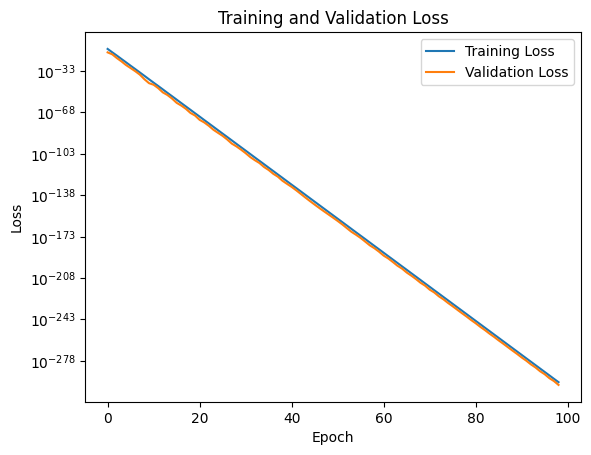

In [34]:
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# save the plot to the specified folder
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

0


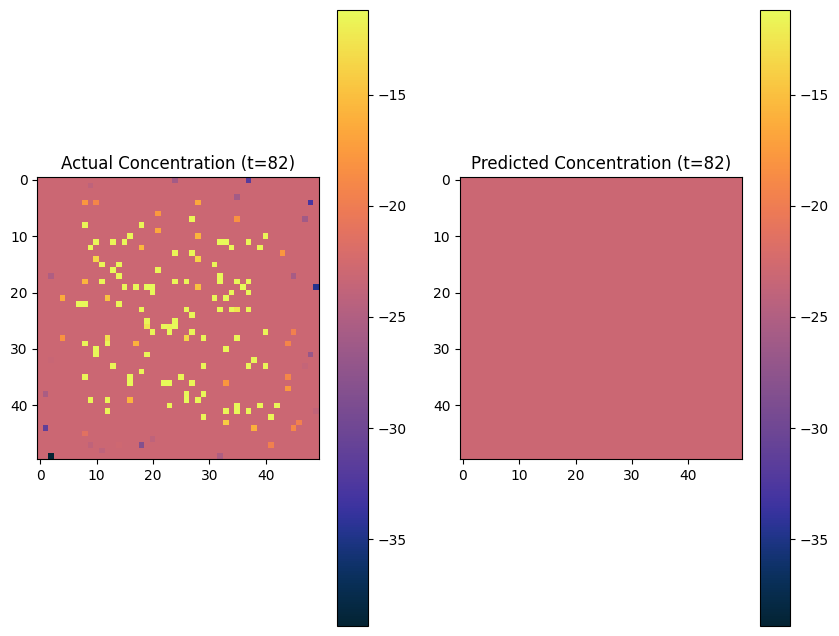

In [48]:
# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)
print(best_timestep)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)
best_y_pred_flattened = np.where(best_y_pred_flattened <= 0, epsilon, best_y_pred_flattened)
best_y_test_flattened = np.where(best_y_test_flattened <= 0, epsilon, best_y_test_flattened)

# Calculate vmin and vmax before reshaping and log transformation
vmin = min(best_y_test_flattened.min(), best_y_pred_flattened.min())
vmax = max(best_y_test_flattened.max(), best_y_pred_flattened.max())

# Apply log scale
log_y_test_flattened = np.log(best_y_test_flattened)
log_y_pred_flattened = np.log(best_y_pred_flattened)

# Reshape the feature data to a 50x50 grid
y_test_grid = np.reshape(log_y_test_flattened[:, 0], (50, 50))
y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (50, 50))

# Update vmin and vmax to handle log transformation correctly
vmin = min(y_test_grid.min(), y_pred_grid.min())
vmax = max(y_test_grid.max(), y_pred_grid.max())

plt.figure(figsize=(10, 8))

# Plotting actual values
plt.subplot(1, 2, 1)
im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
plt.title('Actual Concentration (t=82)')
plt.colorbar(im1)

# Plotting predicted values
plt.subplot(1, 2, 2)
im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
plt.title('Predicted Concentration (t=82)')
plt.colorbar(im2)

# Save the plot to the specified folder
output_dir = 'plots-PINN'
plot_filename = f'{0+1}_grid at t=82.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

1/1 [==============================] - 0s 21ms/step
(2500, 6)
(2500, 6)


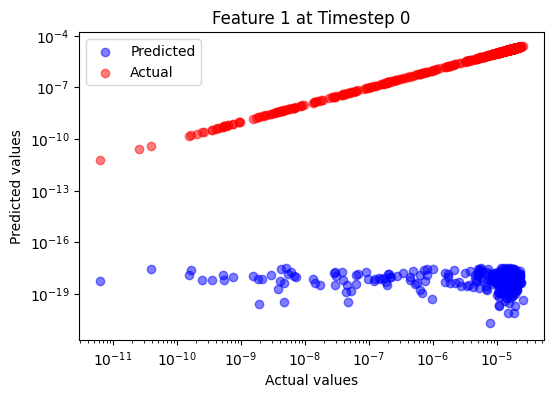

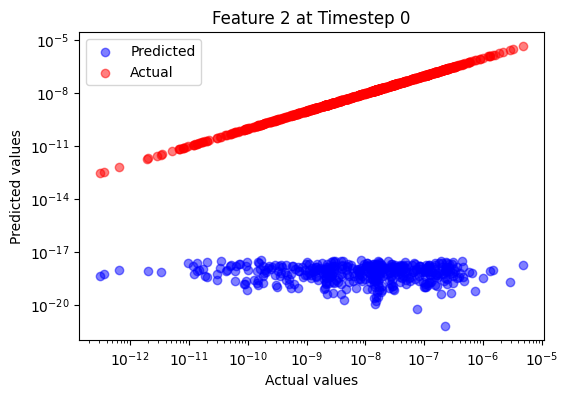

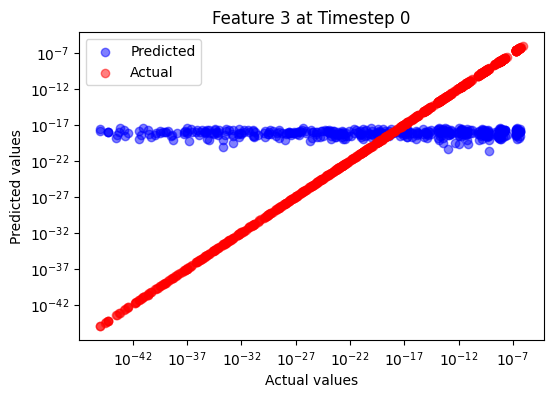

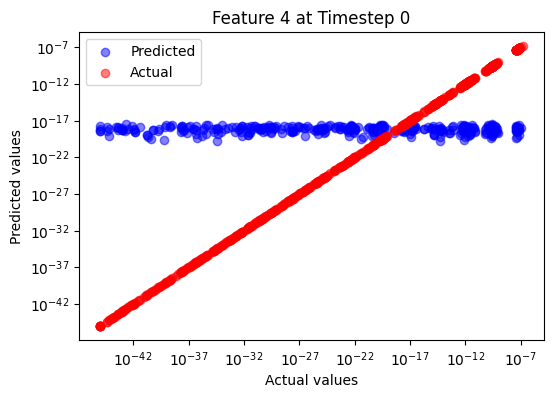

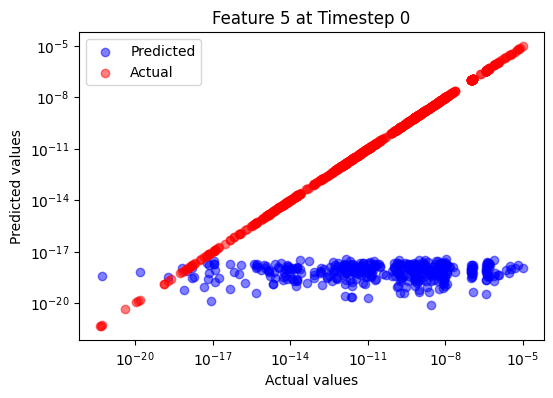

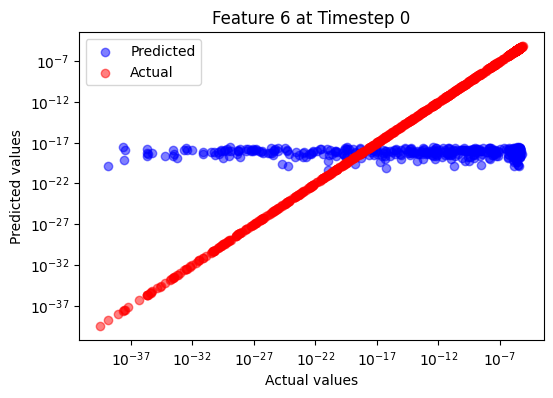

In [38]:
y_pred=model.predict(X_test)
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Create the DataFrame for the best timestep
df_best_timestep = pd.DataFrame({
    'X': X,
    'Y': Y,
    **{f'feature_{i+1}': best_y_pred_flattened[:, i] for i in range(y_pred_shape[-1])}
})

# Save the DataFrame to a CSV file
df_best_timestep.to_csv('data/PINN.csv', index=False)

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

num_features = best_y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(best_y_test_flattened[:, i], best_y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(best_y_test_flattened[:, i], best_y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1} at Timestep {best_timestep}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Save the plot to the specified folder
    plot_filename = f'feature_{i+1}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()